In [4]:
import pandas as pd
import numpy as np
import glob, os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation, digits
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import keras
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.constraints import maxnorm

Movie data from https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data 

In [5]:
# read file
mov_df = pd.read_csv("../data/IMDB-Dataset.csv")
mov_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
stop_words = set(stopwords.words('english'))


def clean_text(text):
    # remove html tags
    soup = BeautifulSoup(text, "lxml")
    new_text = soup.get_text()
    
    # remove numbers and punctuations
    new_text = re.sub("'", ' ', new_text).lower()
    new_text = ''.join(filter(lambda x: x not in punctuation+digits, new_text))
    
    # remove stop words
    tokens = word_tokenize(new_text)
    filt_token = [w for w in tokens if w not in stop_words]
    filt_text = ' '.join(filt_token)
    return filt_text

In [7]:
mov_df['review'] = mov_df['review'].apply(clean_text)
mov_df

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,going disagree previous comment side maltin on...,negative


In [8]:
# convert positive sentiment to 1 and negative sentiment to 0 
# then there are two classes of sentiment 1 and 0 

mov_df['sentiment'] = mov_df['sentiment'].replace({'positive':1, 'negative':0}).astype(int)
mov_df

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49995,thought movie right good job creative original...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary schools n...,0
49998,going disagree previous comment side maltin on...,0


In [9]:
# count sentiment

mov_df['sentiment'].value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

In [10]:
# split into train and test data sets
# select 80% of each sentiment class as the trainning set, the rest 20% are the test set

pos_train = mov_df[mov_df['sentiment']==1][:20000]
neg_train = mov_df[mov_df['sentiment']==0][:20000]
pos_test = mov_df[mov_df['sentiment']==1][20000:]
neg_test = mov_df[mov_df['sentiment']==0][20000:]

train = pd.concat([pos_train, neg_train])
train.reset_index(inplace=True, drop=True)
display(train)

test = pd.concat([pos_test, neg_test])
test.reset_index(inplace=True, drop=True)
display(test)

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,petter mattei love time money visually stunnin...,1
4,probably alltime favorite movie story selfless...,1
...,...,...
39995,tdy probably single worst piece trash ever hit...,0
39996,comes close worst movie ever seen writer start...,0
39997,silly movie looks nice make lot sense one hand...,0
39998,believe sat utter waste time fascinated unspea...,0


,review,sentiment
0,movie stuffed full stock horror movie goodies ...,1
1,romulans come bearing gifts bring war war conq...,1
2,movie heard life growing never seen years ago ...,1
3,let begin saying bigger fan original lonesome ...,1
4,seen bsg tried watch middle show get however s...,1
...,...,...
9995,typical junk comedythere almost laughs genuine...,0
9996,bad plot bad dialogue bad acting idiotic direc...,0
9997,catholic taught parochial elementary schools n...,0
9998,going disagree previous comment side maltin on...,0


In [11]:
all_text = mov_df['review'].values

In [12]:
# count the number of unique words

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the text
tokenizer.fit_on_texts(all_text)
# summarize what was learned
print("Number of reviews: ", tokenizer.document_count)

# count the number of each unique word
word_count = tokenizer.word_counts
#print("Number of unqiue words in the whole dataset: ", word_count, sep='\n')

# total number of unique words 44656 
num_unique_words = len(word_count)
print("total number of unique words: ", num_unique_words)

Number of reviews:  50000
total number of unique words:  206808


In [13]:
#The most common word in the text will be represented as 1, and so on
word_rank = tokenizer.word_index

#print the top 10 words
print("word index: ", {k: word_rank[k] for k in list(word_rank)[:10]}) 

word index:  {'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5, 'would': 6, 'even': 7, 'time': 8, 'really': 9, 'see': 10}


In [14]:
# lengths of all reviews

all_reviewlen =[]
for t in range(len(all_text)):
    
    l = len(all_text[t].split())
    all_reviewlen.append(l)

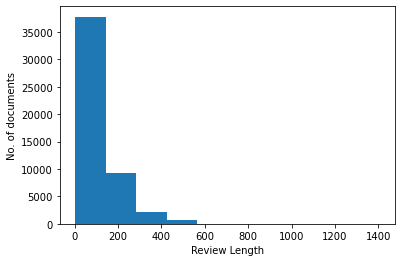

In [15]:
#Plot the histogram of review lengths

plt.hist(all_reviewlen, bins=10)
plt.xlabel('Review Length')
plt.ylabel('No. of documents')
plt.show()

In [16]:
#Select a review length L that 80% of the reviews have a length below it

all_reviewlen.sort()
L = all_reviewlen[40000]
L

161

In [17]:
#Truncate reviews longer than L words and zero-pad reviews shorter than L so that 
#all texts are of length L
#and assume that we are interested in the top 50000 words

# create the tokenizer
token = Tokenizer(num_words=50001)

# fit the tokenizer on training set
test_list = list(test['review'].values)
train_list = list(train['review'].values)

token.fit_on_texts(train_list)

In [18]:
# zero-pad train dataset

sq_train = token.texts_to_sequences(train_list)
print(sq_train[0])

pad_train = pad_sequences(sq_train, maxlen=L, padding='post', truncating='post')
print(pad_train[0])
print(pad_train.shape)


[3, 1831, 912, 54, 2962, 285, 2990, 98, 446, 452, 7240, 19, 55, 3093, 2962, 5453, 15642, 49, 444, 172, 98, 529, 51, 1551, 38, 8048, 5335, 11428, 38, 2222, 5406, 5098, 1262, 260, 444, 3212, 239, 224, 339, 2962, 11038, 230, 13209, 6290, 2412, 919, 2393, 1224, 23060, 387, 4607, 2367, 1023, 6731, 2680, 12633, 280, 16989, 204, 4730, 3006, 387, 226, 7384, 37953, 13843, 4608, 7862, 2136, 15643, 210, 8659, 6596, 11429, 8239, 34245, 33, 122, 19461, 6, 47, 159, 1135, 38, 525, 86, 149, 155, 2840, 678, 77, 1159, 4272, 2260, 1013, 678, 1240, 678, 840, 84, 19, 285, 42, 99, 3093, 1396, 2080, 47, 1399, 166, 1328, 1120, 2962, 78, 9599, 204, 1946, 1973, 444, 444, 7679, 6400, 4983, 2631, 27208, 6291, 364, 477, 14, 130, 13, 9301, 615, 653, 6291, 517, 1023, 18146, 525, 415, 751, 1920, 1023, 420, 54, 2962, 92, 293, 3434, 3130, 14, 1011, 3858, 372]
[    3  1831   912    54  2962   285  2990    98   446   452  7240    19
    55  3093  2962  5453 15642    49   444   172    98   529    51  1551
    38  8048  53

In [19]:
# zero-pad test dataset

sq_test = token.texts_to_sequences(test_list)
print(sq_test[0])

pad_test = pad_sequences(sq_test, maxlen=L, padding='post', truncating='post')
print(pad_test[0])
print(pad_test.shape)

[1, 6412, 253, 1600, 90, 1, 12415, 10844, 18995, 20617, 451, 978, 4685, 2148, 518, 1458, 7, 45027, 215, 2643, 2153, 362, 31860, 14739, 3437, 17346, 6907, 747, 518, 9356, 13903, 1641, 20079, 1153, 10600, 2745, 2599, 9995, 219, 1014, 34399, 1988, 375, 2001, 2496, 1030, 21940, 8512, 20519, 69, 9910, 771, 254, 440, 135, 11275, 68, 42, 17351, 121, 4521, 7, 795, 2077, 1752, 90, 1, 1420, 647, 955, 3, 46, 333, 518, 324, 1458, 149, 1830, 1688, 5012, 3, 795, 2077, 12561, 251, 1047, 5182, 49, 19303, 1, 2009, 430, 1452, 23251, 133, 23589, 100, 1090, 1568, 165, 854, 480, 16, 1458, 3978, 1587, 1956, 60, 279, 1096, 40, 813, 5662, 1794, 1759, 163, 7, 3317, 2411, 4892, 12245, 2372, 71, 1685, 3, 2444, 221, 1834, 1072, 2, 160, 4, 3341, 840, 20, 7, 3341, 6889, 2352, 6595, 723, 157, 2, 777, 2571, 44, 20, 57, 797, 1788, 170, 262, 74, 10877, 157, 3809, 22, 529, 1752, 2366, 7852, 62, 170, 10945, 30943, 37299, 95, 27331, 101, 771, 16, 8352, 103, 1220, 253, 9470, 801, 208, 101, 5768, 3238, 12480, 13722, 42, 392

In [20]:
# sentiment classes y 
y_train = np.array(train['sentiment'])
y_test = np.array(test['sentiment'])
type(y_train)

numpy.ndarray

In [64]:
# Train Multi-Layer Perceptron (MLP)

# with three hidden(dense) layers, 50 ReLUs for each
# one output layer with a single sigmoid neuron
# drop rate is 20% for the first dense layer, 50% for the rest dense layers
# set the number of epochs as 2

model = Sequential()
model.add(Embedding(50001, 32, input_length=L))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

history_mlp = model.fit(pad_train, y_train, epochs=2, batch_size=10, verbose=0, validation_data=(pad_test, y_test))


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 161, 32)           1600032   
                                                                 
 flatten_3 (Flatten)         (None, 5152)              0         
                                                                 
 dense_32 (Dense)            (None, 50)                257650    
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_33 (Dense)            (None, 50)                2550      
                                                                 
 dropout_30 (Dropout)        (None, 50)                0         
                                                                 
 dense_34 (Dense)            (None, 50)              

In [66]:
display(history_mlp.history)
print("MLP last epoch train accuracy: ", history_mlp.history['accuracy'][1])
print("MLP last epoch validation accuracy: ", history_mlp.history['val_accuracy'][1])

{'loss': [0.4103941023349762, 0.1332179605960846],
 'accuracy': [0.7995499968528748, 0.9563500285148621],
 'val_loss': [0.28551235795021057, 0.39908263087272644],
 'val_accuracy': [0.8848000168800354, 0.8676999807357788]}

MLP last epoch train accuracy:  0.9563500285148621
MLP last epoch validation accuracy:  0.8676999807357788


In [67]:
loss1_mlp, accuracy1_mlp = model.evaluate(pad_train, y_train, verbose=0)
loss2_mlp, accuracy2_mlp = model.evaluate(pad_test, y_test, verbose=0)
print("MLP train accuracy: ", accuracy1_mlp)
print("MLP test accuracy: ", accuracy2_mlp)

MLP train accuracy:  0.9959499835968018
MLP test accuracy:  0.8676999807357788


In [24]:
# Train One-Dimensional Convolutional Neural Network (CNN)
 
# with one Convolutional 1D layer which has 32 feature maps, 
# and each of the 32 kernels has size 3
# one Max pooling layer after with sride of 2
# rest of the layers are the same as MLP model 
# set the number of epochs as 5

model_1d = Sequential()
model_1d.add(Embedding(50001, 32, input_length=L))
model_1d.add(Conv1D(32,3, activation='relu'))
model_1d.add(MaxPooling1D(pool_size=2, strides=2))
model_1d.add(Flatten())
model_1d.add(Dense(50, activation='relu'))
model_1d.add(Dropout(0.2))
model_1d.add(Dense(50, activation='relu'))
model_1d.add(Dropout(0.5))
model_1d.add(Dense(50, activation='relu'))
model_1d.add(Dropout(0.5))
model_1d.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model_1d.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model_1d.summary())

history_1d = model_1d.fit(pad_train, y_train, epochs=5, batch_size=10, verbose=0, validation_data=(pad_test, y_test))
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 161, 32)           1600032   
                                                                 
 conv1d (Conv1D)             (None, 159, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 79, 32)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2528)              0         
                                                                 
 dense_4 (Dense)             (None, 50)                126450    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [25]:
print("CNN last epoch train accuracy: ", history_1d.history['accuracy'][4])
print("CNN last epoch validation accuracy: ", history_1d.history['val_accuracy'][4])

CNN last epoch train accuracy:  0.9948999881744385
CNN last epoch validation accuracy:  0.8774999976158142


In [26]:
loss1_1d, accuracy1_1d = model_1d.evaluate(pad_train, y_train, verbose=0)
loss2_1d, accuracy2_1d = model_1d.evaluate(pad_test, y_test, verbose=0)
print("CNN train accuracy: ", accuracy1_1d)
print("CNN test accuracy: ", accuracy2_1d)

CNN train accuracy:  0.9983749985694885
CNN test accuracy:  0.8774999976158142


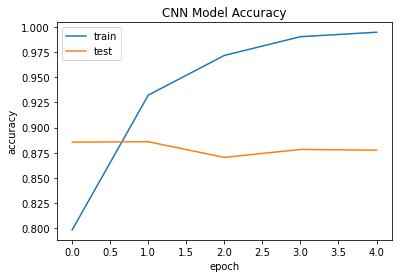

In [63]:
#plot the model accuracy 
plt.plot(history_1d.history['accuracy'])
plt.plot(history_1d.history['val_accuracy'])

plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
# Train Long Short-Term Memory Recurrent Neural Network (LSTM)

# each word is represented to LSTM layer as a vector of 32 elements
# followed by a dense layer with 256 ReLUs
# drop rates are 20% for both LSTM and Dense layer
# set the number of epochs as 10

model_lstm = Sequential()
model_lstm.add(Embedding(50001, 32, input_length=L))
model_lstm.add(LSTM(32, activation='tanh')) 
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))


opt = keras.optimizers.Adam(learning_rate=0.01)
model_lstm.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model_lstm.summary())

history_lstm = model_lstm.fit(pad_train, y_train, epochs=10, batch_size=10, verbose=0, validation_data=(pad_test, y_test))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 161, 32)           1600032   
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 256)               8448      
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,617,057
Trainable params: 1,617,057
No

In [36]:
print("LSTM last epoch train accuracy: ", history_lstm.history['accuracy'][9])
print("LSTM last epoch validation accuracy: ", history_lstm.history['val_accuracy'][9])

LSTM last epoch train accuracy:  0.8971750140190125
LSTM last epoch validation accuracy:  0.8206999897956848


In [37]:
loss1_lstm, accuracy1_lstm = model_lstm.evaluate(pad_train, y_train, verbose=0)
loss2_lstm, accuracy2_lstm = model_lstm.evaluate(pad_test, y_test, verbose=0)
print("LSTM train accuracy: ", accuracy1_lstm)
print("LSTM test accuracy: ", accuracy2_lstm)

LSTM train accuracy:  0.9076250195503235
LSTM test accuracy:  0.8206999897956848


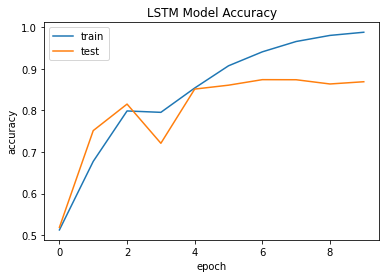

In [68]:
#plot the model accuracy 
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])

plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()